In [ ]:
!pip install neurodsp
!pip install fooof

     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 5.0 MB/s 


In [ ]:
import numpy as np
from scipy import signal
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from neurodsp.spectral import compute_spectrum
from neurodsp.plts.spectral import plot_power_spectra
from fooof import FOOOF

# Function Definitions

## Define Constants

In [ ]:
dt = 0.001 # simulation time step
fs = 1/dt # sampling rate

tk = np.arange(0, 1, dt) #PSC kernel time vector
t = np.arange(0, 60*2, dt) #simulation time vector

# spike train parameters
FR_E = 2 # Firing Rate -- Excitatory
FR_I = 5 # Firing Rate -- Inhibitory
N_E = 8000 # Population -- Excitatory
N_I = 2000 # Population -- Inhibitory

# ampa/gaba PSC kernels
Vr = -65 # Resting Membrane Potential
Ee = 0 # AMPA Reversal Potential -- Excitatory
Ei = -80 # GABA_A Reversal Potential -- Inhibitory
AMPA_tau = np.array([0.1, 2.])/1000. # AMPA Conductance Rise, Decay Time in Seconds
GABA_tau = np.array([0.5, 10.])/1000. # GABA_A Conductance Rise, Decay Time in Seconds

## Synaptic Kernel Function

In [ ]:
def syn_kernel (t, tau):
    # given a specific synaptic kernel type and time constant, this returns a
    # time series of the kernel that spans the time defined (t) in seconds
    #
    # t: time vector in seconds (e.g. t=0:0.001:5)
    # tau: t_decay or [t_rise t_decay] in seconds
    #
    # return: kernel -- the synaptic kernel
    if len(tau) != 2:
        print('Need two time constants for double exponential.')
        return np.array([])
    tpeak = tau[1]*tau[0] / (tau[1]-tau[0]) * np.log(tau[1]/tau[0])
    normf = 1/(-np.exp(-tpeak/tau[0]) + np.exp(-tpeak/tau[1])) # the normalization factor
    kernel = normf * (-np.exp(-t/tau[0])+np.exp(-t/tau[1]))
    return kernel

### PSC Kernel Plot

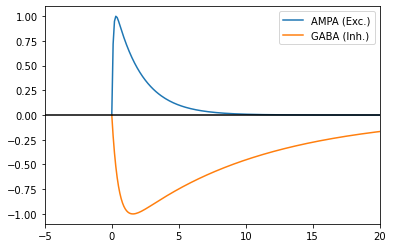

In [ ]:
tk_p = np.arange(0, 0.2, 0.0001) # kernel time vector for the plot
kA_p = syn_kernel(tk_p,AMPA_tau); # AMPA kernel for the plot
kG_p = syn_kernel(tk_p,GABA_tau); # GABA_A kernel for the plot

ax = sns.lineplot(x = tk_p*1e3, y = kA_p)
sns.lineplot(x = tk_p*1e3, y = -kG_p, ax = ax)
ax.axhline(y = 0, color = 'black')
ax.set_xlim(-5,20)
ax.legend(labels=["AMPA (Exc.)","GABA (Inh.)"])

## Poisson Spikes

In [ ]:
def pois_spikes (sim_t, dt, N_neu, FR):
    # simulate population spiking of N neurons firing at FR each, return a
    # single spike train that is the total spiking

    # mu parameter for exponential distribution
    MU = 1. / (N_neu*FR)

    # draw ISI from exp RV 
    ISI = np.random.exponential(MU, int((sim_t+2)/MU))
    spk_times = np.cumsum(ISI)
    spk_times = spk_times[spk_times<=sim_t] # potentially inefficient

    # discretize
    bins = np.arange(0, sim_t, dt) + dt/2 # make discretizing bins
    discretized, _ = np.histogram(spk_times, bins = bins, density = False)
    return discretized

### Poisson Spike Count/dt Plot

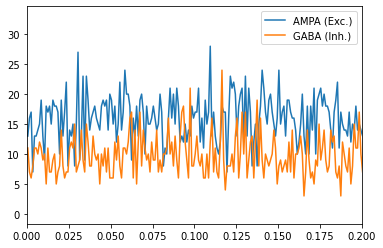

In [ ]:
spk_E = pois_spikes(t[-1]+tk[-1], dt, N_E, FR_E);
spk_I = pois_spikes(t[-1]+tk[-1], dt, N_I, FR_I);
sim_t = t[-1]+tk[-1]
bins = np.arange(0, sim_t, dt) + dt/2
ax = sns.lineplot(x = bins[:5000], y = spk_E[:5000]) # truncate to 5000(arbitrary) to save time
sns.lineplot(x = bins[:5000], y = spk_I[:5000], ax = ax) # truncate to 5000 to save time
ax.set_xlim(0,0.2)
ax.legend(labels=["AMPA (Exc.)","GABA (Inh.)"])

## LFP Time Series Simulation

In [ ]:
def sim_field (EI_ratio, t = 2 * 60, FR_E = 2, FR_I = 5, N_E = 8000, N_I = 2000, tk = 1,
             AMPA_tau = np.array([0.1, 2.])/1000., GABA_tau = np.array([0.5, 10.])/1000.,
             Vr = -65, Ee = 0, Ei = -80, dt=0.001):
    """ FR_E = 2 Firing Rate -- Excitatory
        FR_I = 5 Firing Rate -- Inhibitory
        N_E = 8000 Population -- Excitatory
        N_I = 2000Population -- Inhibitory
        Vr = -65  Resting Membrane Potential
        Ee = 0  AMPA Reversal Potential -- Excitatory
        Ei = -80  GABA_A Reversal Potential -- Inhibitory
        AMPA_tau = np.array([0.1, 2.])/1000.  AMPA Conductance Rise, Decay Time in Seconds
        GABA_tau = np.array([0.5, 10.])/1000.  GABA_A Conductance Rise, Decay Time in Seconds
    """

    fs = 1/dt # sampling rate
    tk = np.arange(0, tk, dt) #PSC kernel time vector
    t = np.arange(0, t, dt) #simulation time vector
    kA = syn_kernel(tk,AMPA_tau)
    kG = syn_kernel(tk,GABA_tau)
    boost = EI_ratio / ((N_I*FR_I*sum(kG))/(N_E*FR_E*sum(kA)))
    spk_E = pois_spikes(t[-1]+tk[-1]+dt, dt, N_E, FR_E)
    spk_I = pois_spikes(t[-1]+tk[-1]+dt, dt, N_I, FR_I)
    GE = np.convolve(spk_E, kA, 'valid') # Total Excitatory Conductance
    GI = np.convolve(spk_I, kG, 'valid') * boost # Total Inhibitory Conductance
    LFP_E = signal.detrend(GE, type = 'constant') * (Ee-Vr) # high-pass drift removal * potential difference
    LFP_I = signal.detrend(GI, type = 'constant') * (Ei-Vr) # high-pass drift removal * potential difference
    return LFP_E, LFP_I, t

# Simulation

## Time Series Simulation

### One trial one ratio test

In [ ]:
EI_ratio = 4
kA = syn_kernel(tk,AMPA_tau)
kG = syn_kernel(tk,GABA_tau)
boost = EI_ratio / ((N_I*FR_I*sum(kG))/(N_E*FR_E*sum(kA)))
spk_E = pois_spikes(t[-1]+tk[-1], dt, N_E, FR_E);
spk_I = pois_spikes(t[-1]+tk[-1], dt, N_I, FR_I);
GE = np.convolve(spk_E, kA, 'valid') # Total Excitatory Conductance
GI = np.convolve(spk_I, kG, 'valid') * boost # Total Inhibitory Conductance
LFP_E = signal.detrend(GE, type = 'constant') * (Ee-Vr) # high-pass drift removal * potential difference
LFP_I = signal.detrend(GI, type = 'constant') * (Ei-Vr) # high-pass drift removal * potential difference
LFP = LFP_E + LFP_I

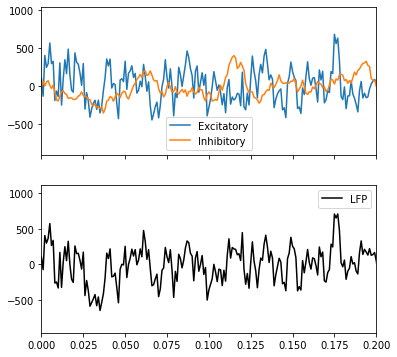

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax = sns.lineplot(x = t[:5000], y = LFP_E[:5000], ax = axes[0]) # used arbitrary length of 5000 to save time
sns.lineplot(x = t[:5000], y = LFP_I[:5000], ax = axes[0])
ax.set_xlim(0,0.2)
ax.legend(labels=["Excitatory","Inhibitory"])

ax = sns.lineplot(x = t[:5000], y = LFP[:5000], color='black', ax = axes[1]) # used arbitrary length of 5000 to save time
ax.set_xlim(0,0.2)
ax.legend(labels=["LFP"])

In [ ]:
t.shape, LFP_E.shape # array length not matched

((120000,), (119998,))

### One Trial One Ratio by Function Call

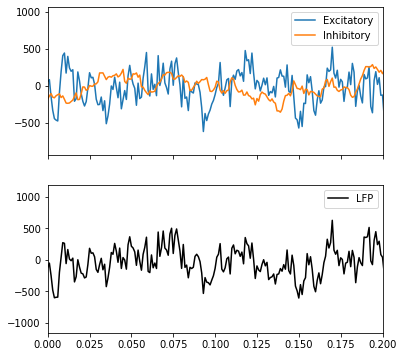

In [ ]:
LFP_E, LFP_I, t = sim_field(4)
LFP = LFP_E + LFP_I
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax = sns.lineplot(x = t[:5000], y = LFP_E[:5000], ax = axes[0]) # used arbitrary length of 5000 to save time
sns.lineplot(x = t[:5000], y = LFP_I[:5000], ax = axes[0])
ax.set_xlim(0,0.2)
ax.legend(labels=["Excitatory","Inhibitory"])

ax = sns.lineplot(x = t[:5000], y = LFP[:5000], color='black', ax = axes[1]) # used arbitrary length of 5000 to save time
ax.set_xlim(0,0.2)
ax.legend(labels=["LFP"])

## Frequency Features Simulation

### PSD Plots

In [ ]:
fs = 1000
LFP_E, LFP_I, t = sim_field(4)
LFP = LFP_E + LFP_I
# PSD Excitatory
freq_e, psd_e = compute_spectrum(LFP_E, fs, method='welch', avg_type='median', nperseg=fs*2)

# PSD Inhibitory
freq_i, psd_i = compute_spectrum(LFP_I, fs, method='welch', avg_type='median', nperseg=fs*2)

# PSD LFP
freq_lfp, psd_lfp = compute_spectrum(LFP, fs, method='welch', avg_type='median', nperseg=fs*2)

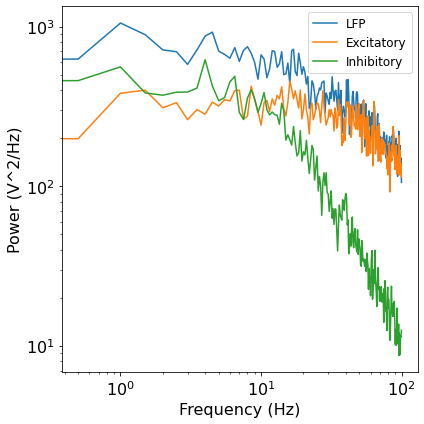

In [ ]:
# Plot the power spectra
plot_power_spectra([freq_lfp[:200], freq_e[:200], freq_i[:200]],
                   [psd_lfp[:200], psd_e[:200], psd_i[:200]],
                   ['LFP', 'Excitatory', 'Inhibitory'])

In [ ]:
LFP_E, LFP_I, t = sim_field(2) # EI ratio = 1 : 2
LFP2 = LFP_E + LFP_I
LFP_E, LFP_I, _ = sim_field(6) # EI ratio = 1 : 6
LFP6 = LFP_E + LFP_I

In [ ]:
fs = 1000
# PSD Excitatory
freq_2, psd_2 = compute_spectrum(LFP2, fs, method='welch', avg_type='median', nperseg=fs*2)

# PSD Inhibitory
freq_6, psd_6 = compute_spectrum(LFP6, fs, method='welch', avg_type='median', nperseg=fs*2)

In [ ]:
freq_2.shape

(1001,)

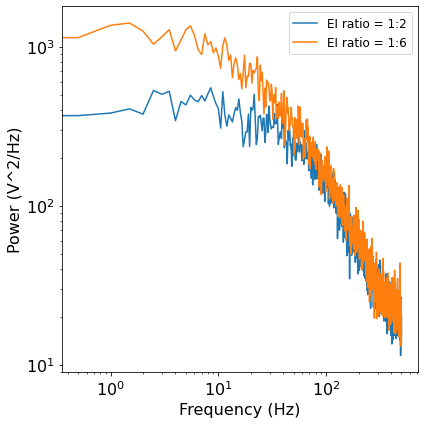

In [ ]:
# Plot the power spectra
fig = plot_power_spectra([freq_2[:1000], freq_6[:1000]],
                   [psd_2[:1000], psd_6[:1000]],
                   ['EI ratio = 1:2', 'EI ratio = 1:6'])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 30 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          3.8299, 0.7962                                          
                                                                                                  
                                       4 peaks were found:                                        
          

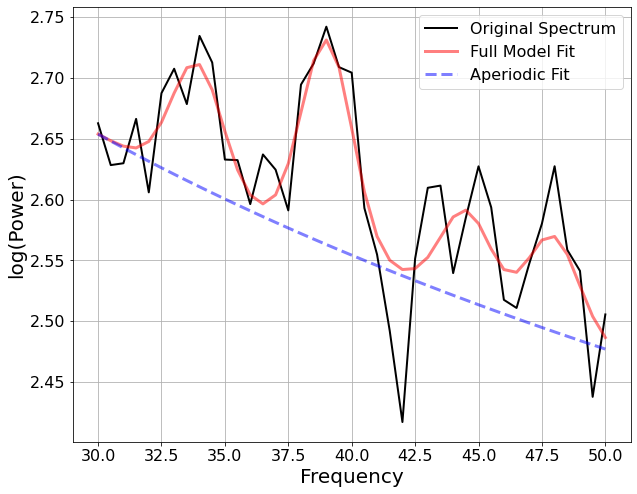

In [ ]:
fm = FOOOF(peak_width_limits=[2, 8], aperiodic_mode='fixed')
freq_range = [30, 50]
# fm.fit(freq_lfp, psd_lfp, freq_range)
fm.report(freq_lfp, psd_lfp, freq_range, plt_log=False)

In [ ]:
# fm.print_results(concise=True)
# fm.aperiodic_params_

0.7885810382962573

### Slope-Ratio Correlation

In [ ]:
EI_ratios = np.arange(2, 6.01, 0.2)
num_trs = 5
fs = 1000
PSDs = np.zeros([fs+1, len(EI_ratios), num_trs])
slopes = np.zeros([len(EI_ratios), num_trs])
# rhos = np.zeros([len(EI_ratios), num_trs])
fs = 1000
freq_range = [30, 50]

for i in range(len(EI_ratios)):
    for tr in range(num_trs):
        LFP_E, LFP_I, _ = sim_field(EI_ratios[i])
        LFP = LFP_E + LFP_I
        freq_lfp, psd_lfp = compute_spectrum(LFP, fs, method='welch', avg_type='median', nperseg=fs*2)
        PSDs[:,i,tr] = psd_lfp
        fm = FOOOF(peak_width_limits=[2, 8], aperiodic_mode='fixed')
        fm.fit(freq_lfp, psd_lfp, freq_range)
        slopes[i, tr] = -fm.aperiodic_params_[1]

In [ ]:
# slopes
df = pd.DataFrame(slopes, columns = ['Trial1','Trial2','Trial3','Trial4','Trial5'])
df['EIRatio'] = 1./EI_ratios

In [ ]:
# df_plot = df.melt('EIRatio', value_name='vals')
df_plot = df.melt('EIRatio')

In [ ]:
df_plot

,EIRatio,variable,value
0,0.500000,Trial1,-0.384331
1,0.454545,Trial1,-0.979705
2,0.416667,Trial1,-0.122167
3,0.384615,Trial1,-0.753589
4,0.357143,Trial1,-0.434601
...,...,...,...
100,0.192308,Trial5,-0.608437
101,0.185185,Trial5,-0.417038
102,0.178571,Trial5,-1.299229
103,0.172414,Trial5,-1.021124


Text(0.5, 1.0, 'EI Ratio, PSD Slope Correlation Plot')

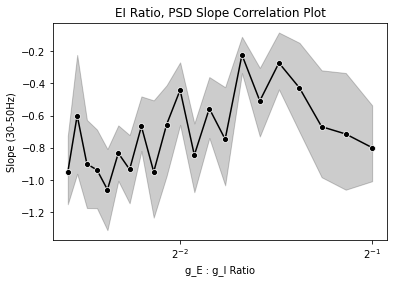

In [ ]:
# ax = sns.lineplot(data=df_plot, x = 'EIRatio', y = 'value', markers=True, dashes=False)
ax = sns.lineplot(data=df_plot, x = 'EIRatio', y = 'value', marker='o', color = 'black')
# ax.invert_xaxis()
ax.set_xscale('log', basex=2)
ax.set_xlabel('g_E : g_I Ratio')
ax.set_ylabel('Slope (30-50Hz)')
ax.set_title('EI Ratio, PSD Slope Correlation Plot')

### Correlation-Frequency Correlation

In [ ]:
# slopes[:,0]

array([-0.96735783, -0.38018018, -0.82417771, -0.26602343, -0.06757825,
       -0.54312039,  0.07162626, -0.81575023, -0.81401563, -0.33344935,
       -0.51923172, -1.20285099,  0.12993057, -0.42626756, -1.30657031,
       -0.55193846, -0.97393943, -0.31425022, -0.98094563, -1.09426332,
       -0.79691135])

In [ ]:
stats.spearmanr(1./EI_ratios, slopes[:,0]).correlation

0.1909090909090909

In [ ]:
# PSDs.shape

(1001, 21, 5)

In [ ]:
win_len = 20
EI_ratios = np.arange(2, 6.01, 0.2)
num_trs = 5
center_freqs = np.arange(20, 160.1, 5)
rhos = np.zeros([len(center_freqs), num_trs])
for f in range(len(center_freqs)):
    freq_range = [center_freqs[f]-win_len/2, center_freqs[f]+win_len/2]
    slopes = np.zeros([len(EI_ratios), num_trs])
    for i in range(len(EI_ratios)):
        for tr in range(num_trs):
            psd_lfp = PSDs[:,i,tr]
            fm = FOOOF(peak_width_limits=[2, 8], aperiodic_mode='fixed')
            fm.fit(freq_lfp, psd_lfp, freq_range);
            slopes[i, tr] = -fm.aperiodic_params_[1]
    for tr in range(num_trs):
        rhos[f,tr] = stats.spearmanr(1./EI_ratios, slopes[:,tr]).correlation

In [ ]:
rhos.shape

(29, 5)

In [ ]:
df2 = pd.DataFrame(rhos, columns = ['Trial1','Trial2','Trial3','Trial4','Trial5'])
df2['CenterFreq'] = center_freqs

Text(0.5, 1.0, 'Spearman Correlation - Fitting Window Plot')

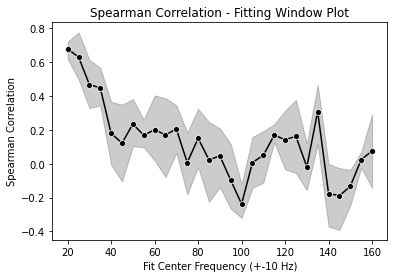

In [ ]:
df2_plot = df2.melt('CenterFreq')
ax = sns.lineplot(data=df2_plot, x = 'CenterFreq', y = 'value', marker='o', color = 'black')
# ax.invert_xaxis()
# ax.set_xscale('log', basex=2)
ax.set_xlabel('Fit Center Frequency (+-10 Hz)')
ax.set_ylabel('Spearman Correlation')
ax.set_title('Spearman Correlation - Fitting Window Plot')